## Greenland: Apply shapefile to mask an xarray dataset (also a 3d map of the surface)

## General context
This serie of notebooks presents the results of preliminary activities to a scientific study to be conducted for CNES (French spatial agency)
with the collaboration of Météo France.<br> 
The study is focusing on the observation of Greenland using specific instruments (microwave radiometers) on-board satellite missions.<br>
The preliminary activities consist on preparation of data handling and data representation.<br>

## References

- Surface, ice thickness and bed of Greenland<br>

     o main reference:<br>
     Morlighem, M., Williams, C. N., Rignot, E., An, L., Arndt,J. E., Bamber, J. L., Zinglersen, K. B. (2017). <br>
     BedMachine v3: Complete bed topography and ocean bathymetry mapping of Greenland from multibeam echo sounding combined with mass conservation, <br>
     Geophysical Research Letters, 44, 11,051– 11,061. https://doi.org/10.1002/2017GL074954 <br>
 
     o latest version of the dataset:<br>
     Morlighem, M. et al. 2021, updated 2021. IceBridge BedMachine Greenland, Version 4.<br>
     Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center.<br>
     https://doi.org/10.5067/VLJ5YXKCNGXO      <br>
     
     o download: https://nsidc.org/data/IDBMG4/versions/4
 

## Objective of the notebook
The objectives are:
- applying a shapefile to mask an xarray dataset
- display a 3d plot of the surface altitude

## The script

The approach is based on:<br>
- geopandas read the shapefile and prepare the mask
- rioxarray to apply the shapefile to the xarray dataset
- lib_cartopy also includes the initialization of the 3d figure

In [2]:
import xarray as xr
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

import os, sys

import numpy as np

import pyproj

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap

import lib_cartopy as lc

The initial file size is about 2.5 Gb and is not included in this notebook.<br>
The first (applied offline) is to subsample the file.

In [2]:
# the initial file size is about 2.Gb 
# let's subsample it to improve the computation time
# load full DEM
# ~ ds = xr.open_dataset('./BedMachineGreenland-2021-04-20.nc')
# subsample
# ~ ds = ds.isel(x=slice(None, None, 10), y=slice(None, None, 10))
# dump
# ~ ds.to_netcdf('files/BedMachineGreenland-2021-04-20_subsampled.nc','w')

Considering the subsampled file, the longitudes and latitudes are computed from the original cartesian coordinated using pyproj.Transformer class.
Longitudes and latitudes are added to the dataset as coordinates.

In [3]:
# load
ds = xr.open_dataset('files/BedMachineGreenland-2021-04-20_subsampled.nc')
# add longitudes / latitudes to the dataset
# Coordinate system of the file
source_crs = 'epsg:3413' 
# Global lat-lon coordinate system
target_crs = 'epsg:4326' 
# transformation function
polar_to_latlon = pyproj.Transformer.from_crs(source_crs, target_crs)
# mesh the coordinates
X, Y = np.meshgrid(ds.x, ds.y)
# transform to longitudes / latitudes
lat, lon = polar_to_latlon.transform(X, Y)
# add coordinates to the dataset
ds.coords['latitude']  = (ds.surface.dims, lat)
ds.coords['longitude'] = (ds.surface.dims, lon)

Let's display the non-clipped dataset (surface elevation dataarray)

/tmp/ipykernel_36324/203648108.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(plot, ax=ax, shrink=0.6, pad=+0.0)


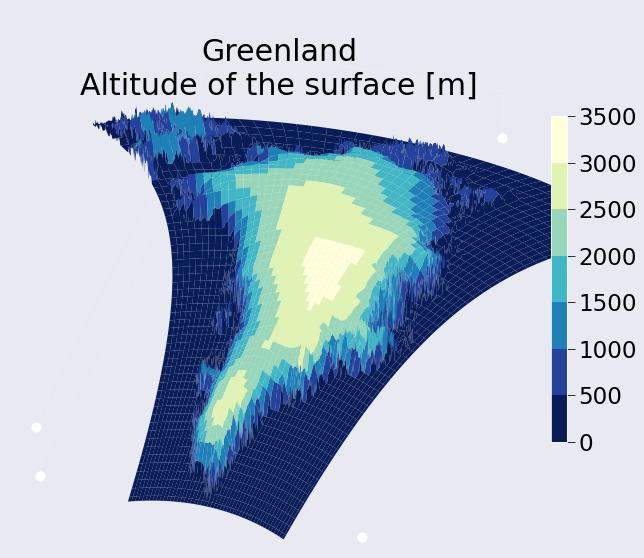

In [4]:
# init figure
fig,ax = lc.init_3d(title='Greenland\nAltitude of the surface [m]')
# get cmap and defined nblevels
cmap = matplotlib.cm.get_cmap('YlGnBu_r', 7)
# Plot surface
plot = ax.plot_surface(X=ds.latitude, Y=ds.longitude, Z=ds['surface'].values, cmap=cmap,vmin=0,vmax=3500)
# Add colorbar
cbar = fig.colorbar(plot, ax=ax, shrink=0.6, pad=+0.0)

Now the shapefile is loaded with geopandas and the crs is applied to the dataset using rio and the rio.clip method is used to mask the dataset according to the shapefile.<br>
Note that the proj4 string included in the netcdf file does not respect the latest standard: +init=epsg:3413' should be 'epsg:3413'<br>
It can be used as it is but it raised a warning: the string is shorten to the useful part.

The clipping process takes about 20s.<br>
The clipped dataset contains weird 1e36 values (probably due to the handling of NaN values): the dataset is filtered to physical altitude.                                            

In [5]:
# load shapefile
geodf = gpd.read_file('files/sd368wz2435.shp')
# load DEM
# subsampled version
ds = xr.open_dataset('files/BedMachineGreenland-2021-04-20_subsampled.nc')
# write crs for compatibility with rio.clip
# note that the proj4 string in the netcdf file does not respect the new standard
# '+init=epsg:3413' should be 'epsg:3413'
# this raises a warning if not corrected
ds = ds.rio.write_crs(ds.proj4[6:])
# clip the xarray dataset to the shapefile geodf
print('clip...')
ds = ds.rio.clip(geodf.geometry.apply(mapping), geodf.crs)
# some weird values appeared (1e36) probably due to NaN values
# filtering out the spurious values
ds = ds.where(ds.surface < 5000)
# dump
ds.to_netcdf('files/BedMachineGreenland-2021-04-20_subsampled_clipped.nc')

clip...


Let's display the non-clipped dataset (surface elevation dataarray)

/tmp/ipykernel_36370/2166980778.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(plot, ax=ax, shrink=0.6, pad=+0.0)


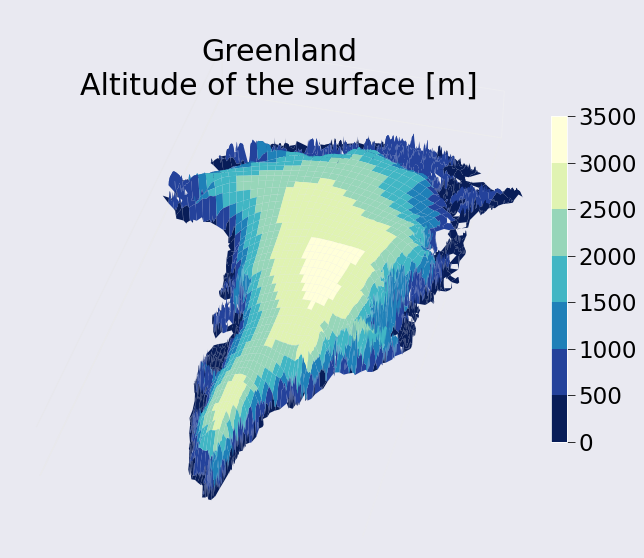

In [3]:
ds = xr.open_dataset('files/BedMachineGreenland-2021-04-20_subsampled_clipped.nc')
# init figure
fig,ax = lc.init_3d(title='Greenland\nAltitude of the surface [m]')
# get cmap and defined nblevels
cmap = matplotlib.cm.get_cmap('YlGnBu_r', 7)
# Plot surface
plot = ax.plot_surface(X=ds.latitude, Y=ds.longitude, Z=ds['surface'].values, cmap=cmap,vmin=0,vmax=3500)
# Add colorbar
cbar = fig.colorbar(plot, ax=ax, shrink=0.6, pad=+0.0)